This notebook documents how the greatest weighted simple path is found between community route start and end nodes as found in the node ranking process.

In [1]:
import osmnx as ox
import networkx as nx
import pandas as pd
import config
import route_planning.helpers.route_planning_helper as helper

Load the graph where route start and end nodes are flagged.

Then create a subgraph for each community,
this will ensure simple paths found stay within a community's boundaries,
reducing computation time.

In [2]:
%%time
G = ox.load_graphml(filepath=f"{config.rp_graphml_path}/route_start_end_flagged.graphml")
helper.convert_edge_weights_to_floats(G)
# nodes = ox.graph_to_gdfs(G, edges=False)
# community_labels = list(nodes["community"].unique())

community_graphs = helper.split_into_community_graphs(G)
# for label in community_labels:
#     community_nodes = []
#     for x, y in G.nodes(data=True):
#         if y["community"] == label:
#             community_nodes.append(x)
#     sub = G.subgraph(community_nodes)
#     community_graphs.append(sub)

CPU times: user 1.45 s, sys: 43.5 ms, total: 1.5 s
Wall time: 1.54 s


Adding a boolean community_route flag to all nodes, nodes on the eventual route will have this set to true

In [3]:
nx.set_node_attributes(G, False, "community_route")

In [4]:
# nodes_per_community = [len(graph.nodes) for graph in community_graphs]
# avg_num_nodes = sum(nodes_per_community) / len(nodes_per_community)
# cutoff = int(avg_num_nodes / 2)

In [4]:
# simplify graph by removing nodes that have only 2 neighbours,
# i.e. those that only make up part of a road,
# while maintaining the weight of the graph
_g = nx.Graph(community_graphs[1])

nodes, edges = ox.graph_to_gdfs(community_graphs[1])

# top 25% of ranked nodes
num = int(len(nodes) * 0.25)

nodes = nodes.astype({"top_n": "int32", "rank": "float"})
nodes.dtypes

y                   float64
x                   float64
osmid                 int64
community            object
rank                float64
geometry           geometry
top_n                 int32
route_flag           object
community_route        bool
dtype: object

In [5]:
exclude_from_removal = list(nodes.nlargest(num, "rank")["osmid"].index)

In [6]:
# nodes_to_remove = [n for n in _g.nodes
#                    if len(list(_g.neighbors(n))) == 2]

nodes_to_remove = [n for n in _g.nodes
                   if len(list(_g.neighbors(n))) == 2 and n not in exclude_from_removal]
# need to check if start/end nodes are included

In [7]:
len(_g.nodes)

422

In [8]:
len(_g.edges)

461

In [9]:
_g.size(weight='weight')

5800.0

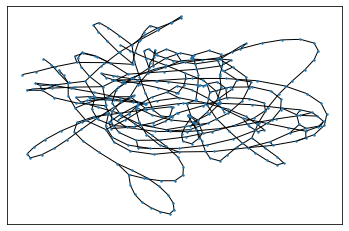

In [9]:
nx.draw_networkx(_g, with_labels=False, node_size=2)

In [10]:
weighted_degrees = dict(list(_g.degree(weight="weight")))
sum(weighted_degrees.values())

11600.0

In [11]:
inc = nx.incidence_matrix(_g, weight="weight")
i = inc.toarray()

In [11]:
# For each of those nodes
for node in nodes_to_remove:
    # get latest node degree values,
    # weighted degree is the sum of all adjacent edge weights
    weighted_degrees = dict(list(_g.degree(weight="weight")))
    # We add an edge between neighbors (len == 2 so it is correct)
    _g.add_edge(*_g.neighbors(node),
                weight=weighted_degrees[node])
    # And delete the node
    _g.remove_node(node)

In [13]:
len(_g.nodes)

89

In [14]:
len(_g.edges)

126

In [13]:
_g.size(weight='weight')

5799.0

In [12]:
start_node = list(nodes[nodes["route_flag"] == "1"]["osmid"])[0]
end_node = list(nodes[nodes["route_flag"] == "2"]["osmid"])[0]

In [ ]:
%%time
paths = list(nx.all_simple_paths(_g, source=start_node, target=end_node, cutoff=int(len(_g.nodes) / 2)))

In [ ]:
edges = _g.edges(data=True)

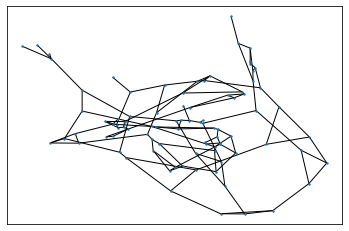

In [24]:
nx.draw_networkx(_g, with_labels=False, node_size=2)

In [25]:
weighted_degrees = dict(list(_g.degree(weight="weight")))
sum(weighted_degrees.values())

11594.0

In [ ]:
g = ox.simplification.simplify_graph(community_graphs[0])
#check = helper.find_highest_weighted_simple_path(community_graphs[1])
#
ox.plot_graph(g)

TypeError: unhashable type: 'list'

In [4]:
%%time

# 100 cutoff = 17 minutes
# 110 cutoff = 45 minutes
#helper.find_highest_weighted_simple_path(community_graphs[1])
routes = []
for graph in community_graphs:
    path = helper.find_highest_weighted_simple_path(graph, cutoff=110)
    print(path)
    routes.append(path)

# start_node = None
# end_node = None
# for x, y in community_graphs[0].nodes(data=True):
#     if "route_flag" in y:
#         if y["route_flag"] == "1":
#             start_node = x
#         elif y["route_flag"] == "2":
#             end_node = x
#ox.plot_graph(community_graphs[0], node_size=10)

# heaviest_path = max((path for path in nx.all_simple_paths(community_graphs[0],
#                                                           source=start_node,
#                                                           target=end_node)),
#                     key=lambda path: path_weight(path))
#paths = list(nx.all_simple_paths(community_graphs[0], source=start_node, target=end_node))

[262459232, 2110993824, 2112562727, 2112562550, 258440720, 2112562637, 2112562834, 2114692416, 258430807, 2739577689, 2114692276, 1979831232, 1979830654, 6302291471, 339828849, 2114692414, 258430916, 2114692923, 2114692649, 2679019572, 2114649718, 1557357468, 1976663550, 258431037, 2114650574, 2114649685, 2354772221, 258431074, 1976663072, 2114649669, 258431117, 262482303, 2114650326, 2114649822, 2114649983, 2114650088, 2114650363, 1411721776, 529130810, 1411690486, 891663587, 2115875593, 2115875669, 2115875525, 2115875630, 891663458, 824799710, 2859800089, 1411703035, 528692201, 7313926535, 258661238, 1297382815, 155939804, 1411714691, 258601516, 1411690478, 1411702960, 258601523]
[258453962, 258453976, 258454085, 258454102, 309927034, 258454188, 1984692868, 1984692752, 1557330797, 258454371, 1630123993, 1630123995, 258454421, 258454435, 262482273, 258449136, 1557324472, 2143150374, 258449094, 258449084, 309963646, 309963645, 2278477863, 843308742, 2062416081, 309963601, 5439449935, 7

[[262459232,
  2110993824,
  2112562727,
  2112562550,
  258440720,
  2112562637,
  2112562834,
  2114692416,
  258430807,
  2739577689,
  2114692276,
  1979831232,
  1979830654,
  6302291471,
  339828849,
  2114692414,
  258430916,
  2114692923,
  2114692649,
  2679019572,
  2114649718,
  1557357468,
  1976663550,
  258431037,
  2114650574,
  2114649685,
  2354772221,
  258431074,
  1976663072,
  2114649669,
  258431117,
  262482303,
  2114650326,
  2114649822,
  2114649983,
  2114650088,
  2114650363,
  1411721776,
  529130810,
  1411690486,
  891663587,
  2115875593,
  2115875669,
  2115875525,
  2115875630,
  891663458,
  824799710,
  2859800089,
  1411703035,
  528692201,
  7313926535,
  258661238,
  1297382815,
  155939804,
  1411714691,
  258601516,
  1411690478,
  1411702960,
  258601523],
 [258453962,
  258453976,
  258454085,
  258454102,
  309927034,
  258454188,
  1984692868,
  1984692752,
  1557330797,
  258454371,
  1630123993,
  1630123995,
  258454421,
  258454435,
  26

In [5]:
all_route_nodes = sum(routes, [])
len(all_route_nodes)

1266

In [6]:
for node in all_route_nodes:
    G.nodes[node]["community_route"] = True
community_route_nodes = [x for x,y in G.nodes(data=True) if y["community_route"]]
len(community_route_nodes)

1266

In [7]:
ox.save_graphml(G, filepath=f"{config.rp_graphml_path}/community_routes_cutoff110.graphml")

In [ ]:
ox.save_graphml(G, filepath=f"{config.rp_graphml_path}/community_routes_cutoff100.graphml")

In [15]:
ox.save_graphml(G, filepath=f"{config.rp_graphml_path}/community_routes.graphml")


In [8]:
nodes, edges = ox.graph_to_gdfs(G)
route_nodes = nodes[(nodes["community_route"])]

route_nodes_graph = ox.graph_from_gdfs(route_nodes, edges)

In [9]:
# convert community labels to integers so that get_node_colors_by_attr can use the community attribute
for x, y in route_nodes_graph.nodes(data=True):
    if "community" in y:
        y["community"] = int(y["community"])

Plot the route start and endpoints, colour based on community

In [ ]:
node_colours = ox.plot.get_node_colors_by_attr(route_nodes_graph,
                                               attr="community",
                                               cmap="tab20")

# graph_from_gdfs creates empty nodes so need
# to update node_colours to include those so
# that plot graph function will work correctly
all_nodes = route_nodes_graph.nodes(data=True)

other_nodes = {x: (0, 0, 0, 0) for x, y in G.nodes(data=True) if x not in node_colours.index}
series = pd.Series(other_nodes)
node_colours = node_colours.append(series)


fig, ax = ox.plot_graph(route_nodes_graph, node_color=node_colours, node_size=50)

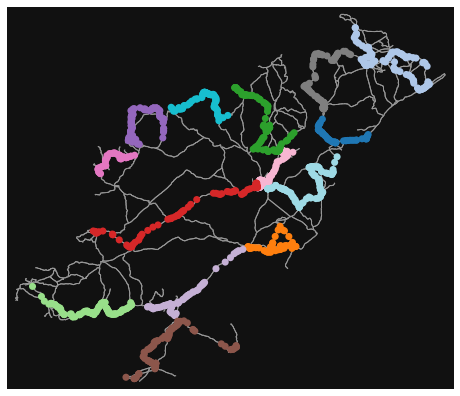

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fef4737ae20>)

In [16]:
node_colours = ox.plot.get_node_colors_by_attr(route_nodes_graph,
                                               attr="community",
                                               cmap="tab20")

# graph_from_gdfs creates empty nodes so need
# to update node_colours to include those so
# that plot graph function will work correctly
all_nodes = route_nodes_graph.nodes(data=True)

other_nodes = {x: (0, 0, 0, 0) for x, y in G.nodes(data=True) if x not in node_colours.index}
series = pd.Series(other_nodes)
node_colours = node_colours.append(series)


ox.plot_graph(route_nodes_graph, node_color=node_colours, node_size=50)


In [17]:
test = ox.load_graphml(filepath=f"{config.rp_graphml_path}/community_routes_cutoff100.graphml")

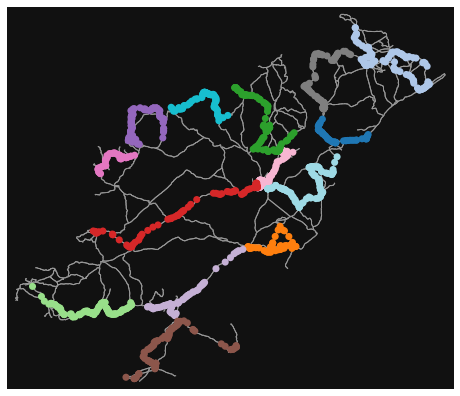

(<Figure size 576x576 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7fef3b7222e0>)

In [18]:
nodes, edges = ox.graph_to_gdfs(G)
route_nodes = nodes[(nodes["community_route"])]

route_nodes_graph = ox.graph_from_gdfs(route_nodes, edges)

# convert community labels to integers so that get_node_colors_by_attr can use the community attribute
for x, y in route_nodes_graph.nodes(data=True):
    if "community" in y:
        y["community"] = int(y["community"])

node_colours = ox.plot.get_node_colors_by_attr(route_nodes_graph,
                                               attr="community",
                                               cmap="tab20")

# graph_from_gdfs creates empty nodes so need
# to update node_colours to include those so
# that plot graph function will work correctly
all_nodes = route_nodes_graph.nodes(data=True)

other_nodes = {x: (0, 0, 0, 0) for x, y in G.nodes(data=True) if x not in node_colours.index}
series = pd.Series(other_nodes)
node_colours = node_colours.append(series)
ox.plot_graph(route_nodes_graph, node_color=node_colours, node_size=50)